In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from tqdm.auto import tqdm
from torch.cuda.amp import autocast, GradScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install kaggle
from google.colab import files
if 'kaggle.json' not in os.listdir():
  files.upload() #API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'tongpython/cat-and-dog'
!unzip 'cat-and-dog.zip'

## Dataset

In [96]:
class Dataset2class(torch.utils.data.Dataset):
  def __init__(self, path1:str, path2:str, size=64):
    super().__init__()
    self.path1 = path1
    self.path2 = path2
    self.size = size

    self.list1 = self.clean_listdir(sorted(os.listdir(path1)))
    self.list2 = self.clean_listdir(sorted(os.listdir(path2)))
    print(f'class 0: {len(self.list1)}')
    print(f'class 1: {len(self.list2)}')

  def __len__(self):
    return len(self.list1) + len(self.list2)

  def __getitem__(self, idx):
    if idx < len(self.list1):
      class_id = 0
      img_path = os.path.join(self.path1, self.list1[idx])
    else:
      class_id = 1
      img_path = os.path.join(self.path2, self.list2[idx-len(self.list1)])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_AREA)
    img = img.transpose([2, 0, 1]) # HWC -> CHW
    t_img = torch.from_numpy(img)
    t_class_id = torch.tensor(class_id)
    return {'img': t_img, 'label': t_class_id}

  def clean_listdir(self, arr):
    new_arr = []
    for i in range(len(arr)):
      if arr[i][-3:] == 'jpg':
        new_arr.append(arr[i])
    return new_arr

In [98]:
def randomshow(data, random):
  for i in list(np.random.randint(0, len(data), random)):
      sample = train_data[i]
      img = sample['img'].numpy().transpose([1, 2, 0])
      label = sample['label'].numpy()
      print(f'class: {label}')
      plt.figure(figsize=(3, 3))
      plt.imshow(img)
      plt.show()

In [99]:
train_dogs_path = '/content/training_set/training_set/dogs'
train_cats_path = '/content/training_set/training_set/cats'
train_data = Dataset2class(train_dogs_path, train_cats_path)

test_dogs_path = '/content/test_set/test_set/dogs'
test_cats_path = '/content/test_set/test_set/cats'
test_data = Dataset2class(test_dogs_path, test_cats_path)

class 0: 4005
class 1: 4000
class 0: 1012
class 1: 1011


class: 0


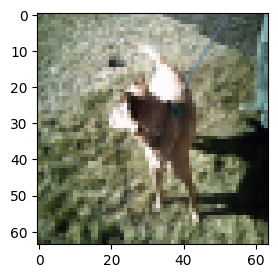

In [100]:
randomshow(train_data, 1)

## DataLoader

In [101]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=False)

In [102]:
for i in train_loader:
  print(i['img'].shape)
  break

torch.Size([16, 3, 64, 64])


## Arch

In [70]:
class VGG16(nn.Module):
  def __init__(self, num_class):
    super().__init__()
    # input size 224x224x3
    self.act = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(2, 2)

    self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)

    self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)

    self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

    self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)

    self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
    self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)

    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(7*7*512, 4096)
    self.linear2 = nn.Linear(4096, 4096)
    self.linear3 = nn.Linear(4096, num_class)


  def forward(self, x):
    out = self.conv1_1(x)
    out = self.act(out)
    out = self.conv1_2(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv2_1(out)
    out = self.act(out)
    out = self.conv2_2(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv3_1(out)
    out = self.act(out)
    out = self.conv3_2(out)
    out = self.act(out)
    out = self.conv3_3(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv4_1(out)
    out = self.act(out)
    out = self.conv4_2(out)
    out = self.act(out)
    out = self.conv4_3(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv5_1(out)
    out = self.act(out)
    out = self.conv5_2(out)
    out = self.act(out)
    out = self.conv5_3(out)
    out = self.act(out)

    out = self.maxpool(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)
    out = self.act(out)
    out = self.linear3(out)

    return out

In [47]:
class SimpleVGG(nn.Module):
  def __init__(self, num_class):
    super().__init__()
    # input size 224x224x3
    self.act = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(2, 2)

    self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
    self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)

    self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
    self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)

    self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

    self.conv4_1 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv4_3 = nn.Conv2d(256, 256, 3, padding=1)

    self.flatten = nn.Flatten()

    self.linear1 = nn.Linear(7*7*256, 4096)
    self.linear2 = nn.Linear(4096, 4096)
    self.linear3 = nn.Linear(4096, num_class)


  def forward(self, x):
    out = self.conv1_1(x)
    out = self.act(out)
    out = self.conv1_2(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv2_1(out)
    out = self.act(out)
    out = self.conv2_2(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv3_1(out)
    out = self.act(out)
    out = self.conv3_2(out)
    out = self.act(out)
    out = self.conv3_3(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.conv4_1(out)
    out = self.act(out)
    out = self.conv4_2(out)
    out = self.act(out)
    out = self.conv4_3(out)
    out = self.act(out)

    out = self.maxpool(out)

    out = self.maxpool(out)

    out = self.flatten(out)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)
    out = self.act(out)
    out = self.linear3(out)

    return out

In [103]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.act = nn.LeakyReLU()
    self.maxpool = nn.MaxPool2d(2, 2)
    # in_channels, out_channels, kernel_size
    self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
    self.conv1 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
    self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128, 30)
    self.linear2 = nn.Linear(30, 2)

  def forward(self, x):
    out = self.conv0(x)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv1(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv2(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv3(out)
    out = self.act(out)

    out = self.adaptivepool(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)
    return out

## Train model

In [104]:
def accuracy(pred, label):
    answer = (F.sigmoid(pred.detach()).numpy() > 0.5) == (label.numpy() > 0.5)
    return answer.mean()

In [108]:
torch.backends.cudnn.benchmark = True # оптимизация алгоритма свертки
# torch.backends.cudnn.deterministic = True

use_amp = True
scaler = GradScaler()

# model = SimpleVGG(2)
# model = VGG16(2)
model = ConvNet()
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
loss_function = loss_function.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [110]:
model.train()
epochs = 10

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
      img, label = sample['img'], sample['label']
      img = img.to(device)
      label = label.to(device)
      label = F.one_hot(label, 2).float()
      optimizer.zero_grad()
      with autocast(use_amp):
        pred = model(img)
        loss = loss_function(pred, label)

      scaler.scale(loss).backward()
      loss_item = loss.item()
      loss_val += loss_item

      scaler.step(optimizer)
      scaler.update()

      acc_current = accuracy(pred.cpu().float(), label.cpu().float())
      acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    print(loss_val/len(train_loader))
    print(acc_val/len(train_loader))

  0%|          | 0/500 [00:00<?, ?it/s]

0.26556266577541826
0.88225


  0%|          | 0/500 [00:00<?, ?it/s]

0.21529585057497025
0.906125


  0%|          | 0/500 [00:00<?, ?it/s]

0.1747220406681299
0.925


  0%|          | 0/500 [00:00<?, ?it/s]

0.14158937802910804
0.94025


  0%|          | 0/500 [00:00<?, ?it/s]

0.11682918311655521
0.950875


  0%|          | 0/500 [00:00<?, ?it/s]

0.08848226244747638
0.9638125


  0%|          | 0/500 [00:00<?, ?it/s]

0.07881571289896964
0.9660625


  0%|          | 0/500 [00:00<?, ?it/s]

0.061687057808041575
0.974375


  0%|          | 0/500 [00:00<?, ?it/s]

0.062014893382787706
0.9755


  0%|          | 0/500 [00:00<?, ?it/s]

0.05979126852750778
0.9775625


In [107]:
torch.cuda.empty_cache()